In [509]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [510]:
df = pd.read_csv('data/all_years.csv', index_col=0)
len(df)

779223

In [511]:
# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']

# Further group raw_inp_vars: a list of categories that will need to be bucketed for visualization, and those that won't
bucket_raw = ['AGEP', 'Off_Threshold', 'PreTaxIncome_PU', 'WKHP']
ok_raw = [var for var in raw_inp_vars if var not in bucket_raw]

id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']

acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']

nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']

output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']

all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

print('Number of columns in groups: ' + str(len(all_columns)))
print('Total columns in dataframe: ' + str(len(df.columns)))
# Double-check that all of the columns in the dataframe are assigned to one and only one group
print("Set of all dataframe columns that don't appear in a group: " + str(set(df.columns).difference(set(all_columns))))

Number of columns in groups: 80
Total columns in dataframe: 80
Set of all dataframe columns that don't appear in a group: set()


In [512]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

In [513]:
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

In [543]:
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
per_vars = ['AGEP', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork'] 
hh_vars = ['LANX', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'Boro', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']
print('Columns weighted by person (' + str(len(per_vars)) + '): ' + str(per_vars) + '\n')
print('Columns weighted by household (' + str(len(hh_vars)) + '): ' + str(hh_vars) + '\n')
neither = [var for var in all_columns if var not in (per_vars + hh_vars)]
print('Not in either(' + str(len(neither)) + '): ' + str(neither))

Columns weighted by person (29): ['AGEP', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'MSP', 'MAR', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'MRGP_adj', 'RNTP_adj', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork']

Columns weighted by household (36): ['LANX', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'Boro', 'PreTaxIncome_PU', 'NYCgov_EITC', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat', 'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'NYCgov_PovGap', 'NYCgov_PovGapIndex']

Not in either(15): ['HIUnit_Head', 'Off_Thr

In [516]:
cats = df.replace(nyc_codes)
cats = cats.replace(raw_codes)
cats = cats.replace({'NYCgov_Pov_Stat': {1: 'Pov', 2:'Not Pov'}, 'Off_Pov_Stat': {1:'Pov', 2:'Not Pov'}})
cats.loc[cats['HIUnit_Head'].isna(), 'HIUnit_Head'] = 'NA'

In [517]:
for col in dict(raw_codes, **nyc_codes):
    print(col + ': ' + str(cats[col].unique()))

Boro: ['Brooklyn' 'Queens' 'Bronx' 'Manhattan' 'Staten Island']
CIT: ['Naturalized' 'Birth' 'No' 'US Parents' 'Territories']
DIS: ['No' 'Yes' 'NA']
ENG: ['Only Eng' '<5' 'Not well' 'Not at all' 'Very Well' 'Well']
ESR: ['NILF' 'EMP' '<16' 'UNEMP' 'EMP/NAW' 'AF' 'AF/NAW']
Ethnicity: ['Black' 'White' 'Hispanic' 'Asian' 'Other']
HHT: ['Malone' 'MNAlone' 'WNM' 'MAR' 'Walone' 'MNW' 'WNalone']
HIUnit_Head: ['NA' 'Head' 'Not Head']
HousingStatus: ['Own-Mortgage' 'OwnF&C' 'Subsidy' 'Regulated' 'MarketRate' 'OtherReg'
 'Public' 'NoCash' 'Mitchell' 'NA']
JWTR: ['NA' 'Car' 'Bus' 'Other' 'Subway' 'Taxi' 'Walk' 'Home' 'RR' 'Motorcycle'
 'Ferry' 'Bike' 'Streetcar']
LANX: ['Only Eng' 'NA' 'Yes']
MAR: ['Divorced' 'Never Married' 'Widowed' 'Separated' 'Married']
MSP: ['Divorced' 'Never Married' 'Widowed' 'Separated' 'Yes' 'NA'
 'Spouse absent']
REL: ['Self' 'Parent-in-law' 'Child' 'Spouse' 'Adopted' 'Roommate' 'Grandchild'
 'Sibling' 'Stepchild' 'Parent' 'Child-in-law' 'Other' 'Boarder' 'Partner'
 'Oth

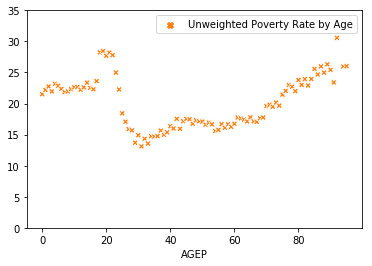

In [518]:
n = 0
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0).rename(columns={'Pov': 'Unweighted Poverty Rate by Age', 'Not Pov': ''})
chart = sns.scatterplot(data=pcts)
chart.set_ylim(0,35)
pass

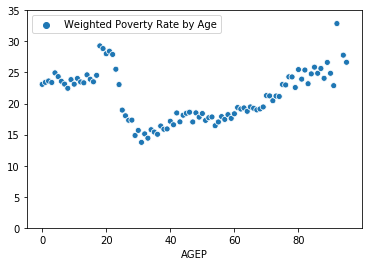

In [519]:
n = 0
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack().rename(columns={weight: 'Weighted Poverty Rate by Age'})
chart = sns.scatterplot(data=pcts)
chart.set_ylim(0,35)
pass

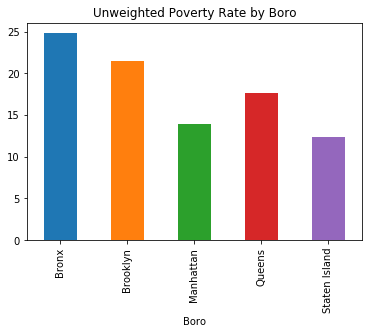

In [520]:
n = 1
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

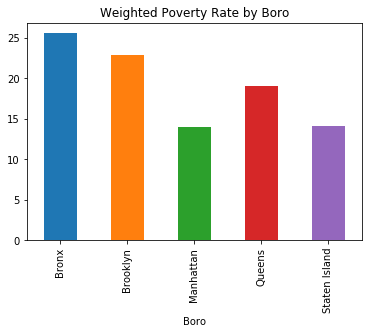

In [521]:
n = 1
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

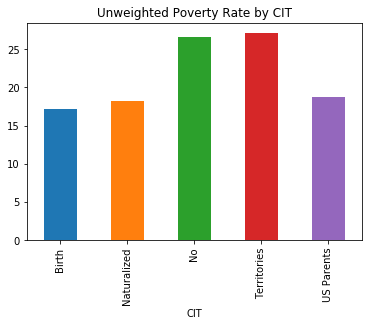

In [522]:
n = 2
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

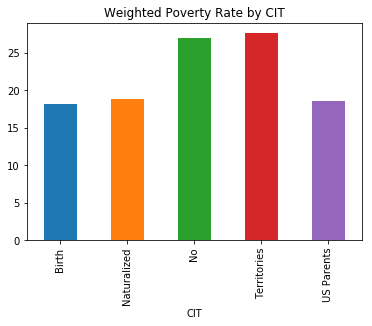

In [523]:
n = 2
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

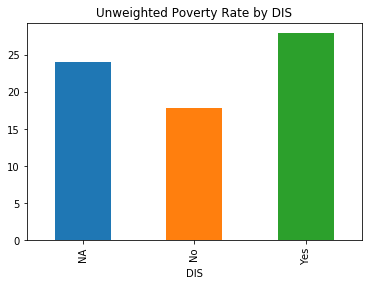

In [524]:
n = 3
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

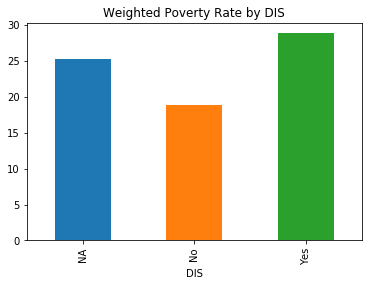

In [525]:
n = 3
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

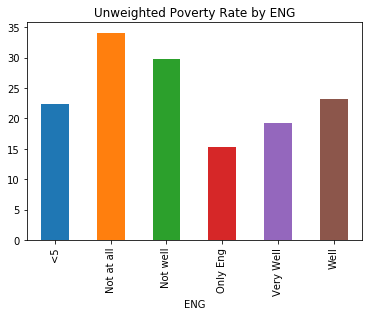

In [526]:
n = 4
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

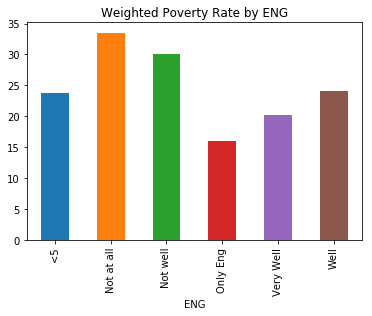

In [527]:
n = 4
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

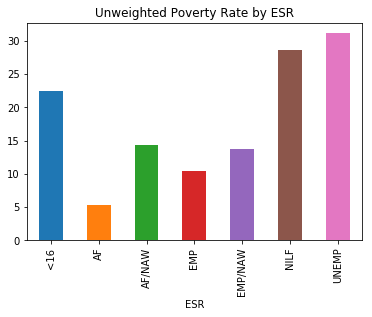

In [528]:
n = 5
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

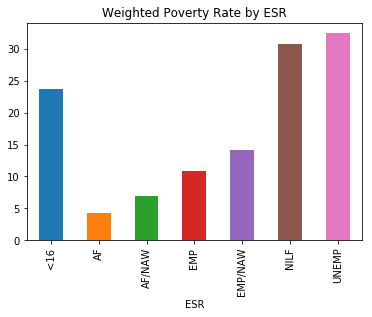

In [529]:
n = 5
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

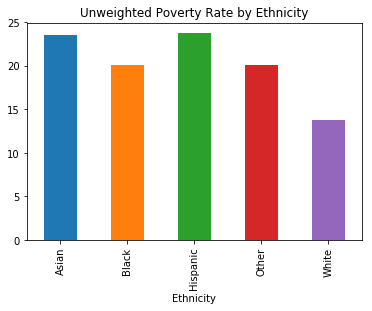

In [531]:
n = 6
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

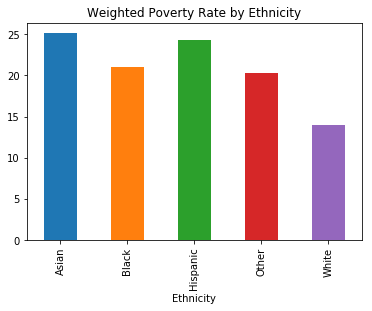

In [532]:
n = 6
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

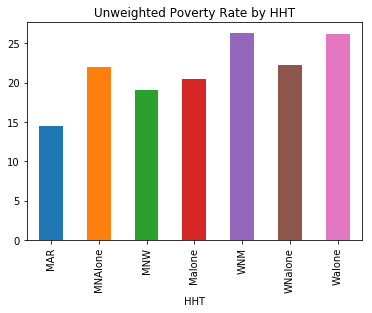

In [533]:
n = 7
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

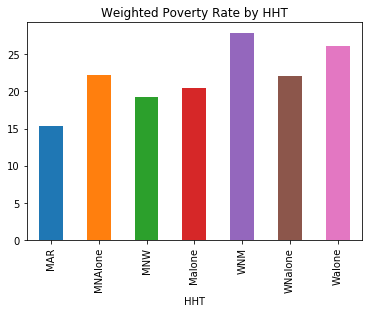

In [534]:
n = 7
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

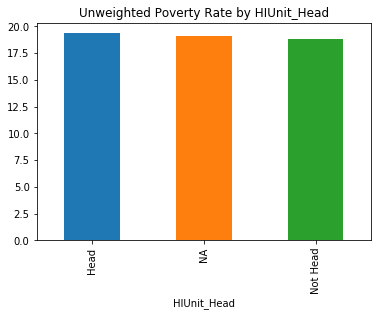

In [535]:
n = 8
labels = raw_inp_vars
counts = pd.crosstab(cats.NYCgov_Pov_Stat, cats[labels[n]]).T
subtotals = counts.sum(axis=1)
pcts = counts.div(subtotals/100, axis=0)
pcts['Pov'].plot(kind='bar', title='Unweighted Poverty Rate by ' + str(labels[n]))

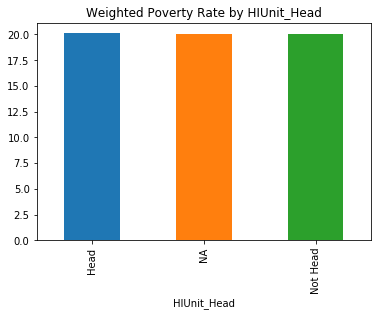

In [536]:
n = 8
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
counts = cats[['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))

In [530]:
n = 1
labels = raw_inp_vars
weight = 'PWGTP' if labels[n] in per_vars else 'WGTP'
weight = 'PWGTP'
counts = cats.loc[(cats.Year == 2013), ['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
#counts = cats.loc[(cats.Year == 2016) & (cats.Povunit_Rel == 'Head'), ['NYCgov_Pov_Stat', labels[n], weight]].groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
#pcts[weight]['Pov'].plot(kind='bar', title='Weighted Poverty Rate by ' + str(labels[n]))
pcts
#cats.loc[(cats.Year == 2016) & (cats.NYCgov_Pov_Stat == 1) & (cats.Povunit_Rel == 1), ['NYCgov_Pov_Stat', labels[n], weight]]#.groupby([labels[n], 'NYCgov_Pov_Stat']).sum()
#cats[['Year', 'NYCgov_Pov_Stat', 'Povunit_Rel']]
#cats.loc[(cats.Year == 2016) & (cats.Povunit_Rel == 'Head')]#(cats.NYCgov_Pov_Stat == 'Pov') & (cats.Povunit_Rel == 'Head')]#,['NYCgov_Pov_Stat', labels[n], weight]]#.groupby([labels[n], 'NYCgov_Pov_Stat']).sum()

PWGTP           
NYCgov_Pov_Stat    Not Pov        Pov
Boro                                 
Bronx            75.031084  24.968916
Brooklyn         77.867453  22.132547
Manhattan        84.231968  15.768032
Queens           79.060684  20.939316
Staten Island    84.554739  15.445261

In [ ]:
'PWGTP' if labels[n] in per_vars else 'WGTP'

In [508]:
#t2016 = pd.read_csv('data/NYCgov_Poverty_Measure_Data__2016_.csv')
#t2016.head()
t2013 = pd.read_csv('data/NYCgov_Poverty_Measure_Data__2013_.csv')
t2013.head()
#cleaned_2013 = df.loc[df.Year == 2013, 'SERIALNO'].unique()
#all_2013= t2013['SERIALNO'].unique()
#all_2013 - cleaned_2013
#t2013.loc[~t2013.SERIALNO.isin(df.loc[df.Year == 2013].SERIALNO), ['PWGTP', 'NYCgov_Pov_Stat', 'Boro']]
#removed = t2013.loc[~t2013.SERIALNO.isin(df.loc[df.Year == 2013].SERIALNO)]
#r_list = removed.columns[removed.isna().any()].tolist()
#r_list.sort()

#len(t2013)

# Create a copy for comparison later, then do initial cleanup
t2013_orig = t2013.copy()
    
# Create temporary column 'FivePlus' to make it easier to distribute the ENG NaNs appropriately
t2013['FivePlus'] = t2013.AGEP >= 5

# Change the rows where ENG is null and over age five to be 5 (they only speak English)
# Change the rows where ENG is null and under age five to be 0 
t2013.loc[((t2013.ENG.isnull()) & (t2013.FivePlus == True)), 'ENG'] = 5
t2013.loc[((t2013.ENG.isnull()) & (t2013.FivePlus == False)), 'ENG'] = 0

# Remove the temporary column created above
t2013.drop('FivePlus', axis=1, inplace=True)
   
# Change null values to zeros where the person is under age or the question doesn't make sense for that person
# (e.g. a five-year-old is neither married nor unmarried, they're just a five-year-old)
t2013.loc[t2013.JWTR.isnull(), 'JWTR'] = 0
t2013.loc[t2013.WKW.isnull(), 'WKW'] = 0
t2013.loc[t2013.ESR.isnull(), 'ESR'] = 0
t2013.loc[t2013.MSP.isnull(), 'MSP'] = 0
t2013.loc[t2013.LANX.isnull(), 'LANX'] = 0
t2013.loc[t2013.EducAttain.isnull(), 'EducAttain'] = 0
t2013.loc[t2013.SCHL.isnull(), 'SCHL'] = 0
if 'DS' in t2013.columns:
    t2013.loc[t2013.DS.isnull(), 'DS'] = 0
    
# Compare nulls between the original and new datasets
check = t2013 - t2013_orig
check1 = check.ne(0).sum()
check1 = check1[check1 > 0].sort_values(ascending=False)
t2013_orig_nulls = t2013_orig.isnull().sum()
t2013_orig_nulls = t2013_orig_nulls[t2013_orig_nulls > 0].sort_values(ascending=False)
print('Number of changes by column equals original columns: \n' + str(t2013_orig_nulls == check1) + '\n')
    
# Drop any remaining rows with any NaNs and check we haven't dropped too many
mask = t2013.isna().any(1)
t2013[mask]
#mask
mask2016 = t2016.isna().any(1)
t2016[mask2016]

Number of changes by column equals original columns: 
ENG              True
JWTR             True
WKW              True
ESR              True
MSP              True
LANX             True
EducAttain       True
SCHL             True
Off_Threshold    True
dtype: bool



,SERIALNO,SPORDER,PWGTP,WGTP,AGEP,CIT,REL,SCH,SCHG,SCHL,...,NYCgov_FICAtax,NYCgov_IncomeTax,NYCgov_Income,NYCgov_EITC,Off_Threshold,Off_Pov_Stat,NYCgov_Threshold,NYCgov_Pov_Stat,NYCgov_PovGapIndex,NYCgov_PovGap
0,39,1,53,52,51,1,0,1,0,18.0,...,0.000000,-99.278427,17824.071786,0.000000,12486.0,2,15017.129826,2,0.000000,0.000000
1,55,1,30,30,60,1,0,1,0,20.0,...,13874.486760,30551.996336,128434.045904,0.000000,29854.0,2,46330.388118,2,0.000000,0.000000
2,55,2,32,30,52,1,1,1,0,16.0,...,13874.486760,30551.996336,128434.045904,0.000000,29854.0,2,46330.388118,2,0.000000,0.000000
3,55,3,48,30,26,1,2,1,0,21.0,...,13874.486760,30551.996336,128434.045904,0.000000,29854.0,2,46330.388118,2,0.000000,0.000000
4,55,4,29,30,20,1,2,1,0,16.0,...,13874.486760,30551.996336,128434.045904,0.000000,29854.0,2,46330.388118,2,0.000000,0.000000
5,55,5,29,30,20,1,2,2,15,19.0,...,13874.486760,30551.996336,128434.045904,0.000000,29854.0,2,46330.388118,2,0.000000,0.000000
6,69,1,192,192,39,1,0,1,0,19.0,...,6166.438560,20154.567899,52357.244541,0.000000,12486.0,2,15017.129826,2,0.000000,0.000000
7,210,1,37,38,26,5,0,1,0,23.0,...,6166.438560,38807.270791,83368.212649,0.000000,12486.0,2,15017.129826,2,0.000000,0.000000
8,261,1,151,150,36,1,0,1,0,21.0,...,14291.492168,32219.419539,94308.848294,0.000000,28643.0,2,36093.962800,2,0.000000,0.000000
9,261,2,131,150,36,1,1,1,0,21.0,...,14291.492168,32219.419539,94308.848294,0.000000,28643.0,2,36093.962800,2,0.000000,0.000000


In [ ]:
weight = 'PWGTP'
counts = t2016[['NYCgov_Pov_Stat', 'Ethnicity', weight]].groupby(['Ethnicity', 'NYCgov_Pov_Stat']).sum()
subtotals = counts.sum(level=0)
pcts = 100 * counts / subtotals
pcts = pcts.unstack('NYCgov_Pov_Stat')
pcts

In [471]:
#t2016.subtract(df.loc[df.Year == 2016])
#df.loc[df.Year == 2016]
new = df.loc[df.Year == 2016]
del new['Year']
t2016.subtract(new).notnull()
#new
t2016.loc[(t2016.NYCgov_Income < -50000) | (t2016.Off_Threshold.isna()), ['PWGTP', 'NYCgov_Pov_Stat', 'Boro']]

,PWGTP,NYCgov_Pov_Stat,Boro
10411,72,1,4
10657,118,1,3
11742,61,1,3
14739,127,1,2
16302,244,1,3
18316,187,1,3
18557,145,1,3
22202,226,1,3
28385,63,1,2
30688,225,1,3


In [ ]:
pd.crosstab(cats.Boro, cats.NYCgov_Pov_Stat).plot(kind='bar')

In [ ]:
#pd.crosstab(cats.NYCgov_Pov_Stat, cats.Boro).plot(kind='bar')
#pd.crosstab(cats.Boro, cats.NYCgov_Pov_Stat).plot(kind='bar')

#pd.crosstab(cats.Boro, cats.NYCgov_Pov_Stat).plot(kind='pie', subplots=True)
pd.crosstab(cats.NYCgov_Pov_Stat, cats.Boro).plot(kind='pie', subplots=True, figsize=(24,14))
pd.crosstab(cats.NYCgov_Pov_Stat, cats.Boro)

In [ ]:
tot_by_boro = cats[['Boro','PWGTP', 'NYCgov_Pov_Stat']].groupby(['Boro', 'NYCgov_Pov_Stat']).sum().sum(level=0)
pcts = 100 * cats[['Boro','PWGTP', 'NYCgov_Pov_Stat']].groupby(['Boro', 'NYCgov_Pov_Stat']).sum()/tot_by_boro
pcts.unstack('Boro').plot(kind='pie', subplots=True, figsize=(24,14))
pcts

In [ ]:
nyc_corr.abs().sort_values(ascending=False)

In [ ]:
(nyc_corr - off_corr).abs().sort_values(ascending=False)

In [ ]:
raw_inp_vars
#df[['NYCgov_Pov_Stat', 'AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP', 'NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']].corr()['NYCgov_Pov_Stat'].abs().sort_values(ascending=False)
nyc_corr = df.corr()['NYCgov_Pov_Stat']
off_corr = df.corr()['Off_Pov_Stat']
(nyc_corr - off_corr).sort_values(ascending=False)

In [ ]:
sns.jointplot(x='Boro', y='NYCgov_Pov_Stat', data=cats[['Boro', 'NYCgov_Pov_Stat']])